In [40]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers.evaluation import TripletEvaluator
import torch
from torch.utils.data import DataLoader
import math
import os
import sys
import warnings
import logging
import json
import random
from datasets import load_dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)


In [2]:
MODEL_NAME = 'all-MiniLM-L6-v2'
DATA_FILE = "../data/books_triplets.parquet"
OUTPUT_PATH = f'sbert-output/finetuning-{MODEL_NAME}-books'
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'eval'), exist_ok=True) # For evaluator output

## 1. Load Dataset

In [3]:
books_df = dd.read_parquet('../data/reduced_books.parquet')

In [4]:
def analyze_dataframe(df):
    # Get column info
    cols = df.columns
    dtypes = df.dtypes
    
    # Calculate total rows
    total_rows = len(df.compute())
    
    # Initialize lists to store results
    results = []
    
    # Analyze each column
    for col in cols:
        # Count non-null values
        non_null_count = df[col].count().compute()
        null_count = total_rows - non_null_count
        null_percentage = (null_count / total_rows) * 100
        
        results.append({
            'Column': col,
            'Data Type': str(dtypes[col]),
            'Non-Null Count': non_null_count,
            'Null Count': null_count,
            'Null Percentage': f'{null_percentage:.2f}%'
        })
    
    # Convert results to pandas DataFrame for better display
    results_df = pd.DataFrame(results)
    return results_df.sort_values('Null Percentage', ascending=False)

# Display the analysis
print("DataFrame Analysis:")
display(analyze_dataframe(books_df))

DataFrame Analysis:


,Column,Data Type,Non-Null Count,Null Count,Null Percentage
0,isbn,string,17663,0,0.00%
15,publisher,string,17663,0,0.00%
27,title,string,17663,0,0.00%
26,work_id,string,17663,0,0.00%
25,ratings_count,string,17663,0,0.00%
24,book_id,int64,17663,0,0.00%
23,image_url,string,17663,0,0.00%
22,url,string,17663,0,0.00%
21,publication_year,string,17663,0,0.00%
20,edition_information,string,17663,0,0.00%


In [5]:
books_df = books_df.compute()

In [6]:
books_df.set_index('book_id', inplace=True)


In [7]:
books_df.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,ratings_count,work_id,title,title_without_series
book_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6066819,0743294297,3282,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,"[2285777, 5941079, 3134684]",Addie Downs and Valerie Adler were eight when ...,Hardcover,https://www.goodreads.com/book/show/6066819-be...,[fb1de694-168f-4a44-b604-34169f4cbf0e],Atria Books,368,14,9780743294294,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,51184,6243154,Best Friends Forever,Best Friends Forever
89375,0800759494,2885,[],US,,"[{'count': '9381', 'name': 'to-read'}, {'count...",,false,3.91,B00B853QPM,"[53817, 254389, 8964, 8139321]",As he is driving home from a minister's confer...,,https://www.goodreads.com/book/show/89375.90_M...,"[e1cead2a-37b0-4231-b350-1d6cf5a5c07f, 8c38df9...",,,,9780800759490,,,,https://www.goodreads.com/book/show/89375.90_M...,https://s.gr-assets.com/assets/nophoto/book/11...,68157,2957021,90 Minutes in Heaven: A True Story of Death an...,90 Minutes in Heaven: A True Story of Death an...
11731782,,346,[274178],US,en-GB,"[{'count': '6001', 'name': 'to-read'}, {'count...",B0055Q8HDG,true,3.86,B0055Q8HDG,"[10950666, 11948797, 12711899, 11187203, 12901...",Sherry has always known there was something ou...,Kindle Edition,https://www.goodreads.com/book/show/11731782-c...,[b45ea77a-77e3-4efc-a8ae-0a8de1007f59],,360,12,,6,,2011,https://www.goodreads.com/book/show/11731782-c...,https://images.gr-assets.com/books/1352764436m...,5125,16680541,"Collide (Collide, #1)","Collide (Collide, #1)"
54270,0395083621,1396,[],US,en-US,"[{'count': '549', 'name': 'history'}, {'count'...",,false,3.13,B008QI6EHQ,[3831344],"Madman, tyrant, animal - history has given Ado...",,https://www.goodreads.com/book/show/54270.Mein...,[caafdcb9-33c8-4284-9df3-7c2d27a2ef8b],Houghton Mifflin Company,384,,9780395083628,,,,https://www.goodreads.com/book/show/54270.Mein...,https://images.gr-assets.com/books/1395618385m...,16837,2049624,Mein Kampf,Mein Kampf
38568,0060773758,1223,[163036],US,en-US,"[{'count': '7188', 'name': 'to-read'}, {'count...",,false,3.91,B000GCFWXW,"[225669, 50789, 46481, 780878]",That hot guy tied to Lissianna Argeneau's bed?...,Mass Market Paperback,https://www.goodreads.com/book/show/38568.A_Qu...,[3f4997a5-de3c-45d0-932b-ce8540afcccc],Avon,360,25,9780060773755,10,,2005,https://www.goodreads.com/book/show/38568.A_Qu...,https://images.gr-assets.com/books/1410129015m...,32140,2621331,A Quick Bite (Argeneau #1),A Quick Bite (Argeneau #1)


In [8]:
# In cell with id e87c3b0c
def extract_genres(popular_shelves):
    """
    Extracts potential genres from a list of popular shelves dictionaries,
    adding only the base genre keyword found.

    Args:
        popular_shelves: A list of dictionaries, where each dictionary has
                         'count' and 'name' keys.

    Returns:
        A list of unique base genre names found, or an empty list on error.
    """
    try:
        if not isinstance(popular_shelves, np.ndarray) or len(popular_shelves) == 0:
            return []
        
        # Use a set to store unique base genres found
        found_genres = set() 
        
        genre_keywords = [
            'action', 'adventure', 'comedy', 'crime', 'mystery', 'textbook', 'children', 'mathematics', 'fantasy',
            'historical', 'horror', 'romance', 'satire', 'science fiction',
            'scifi', 'speculative fiction', 'thriller', 'western', 'paranormal',
            'dystopian', 'urban fantasy', 'contemporary', 'young adult', 'ya',
            'middle grade', 'children\'s', 'literary fiction', 'magic realism',
            'historical fiction', 'gothic', 'suspense', 'biography', 'memoir',
            'nonfiction', 'poetry', 'drama', 'historical romance',
            'fantasy romance', 'romantic suspense', 'science fiction romance',
            'contemporary romance', 'paranormal romance', 'epic fantasy',
            'dark fantasy', 'sword and sorcery', 'steampunk', 'cyberpunk',
            'apocalyptic', 'post-apocalyptic', 'alternate history',
            'superhero', 'mythology', 'fairy tales', 'folklore', 'war',
            'military fiction', 'spy fiction', 'political fiction', 'social science fiction',
            'techno-thriller', 'medical thriller', 'legal thriller',
            'psychological thriller', 'cozy mystery', 'hardboiled', 'noir',
            'coming-of-age', 'lgbtq+', 'christian fiction', 'religious fiction',
            'humor', 'travel', 'food', 'cooking', 'health', 'self-help',
            'business', 'finance', 'history', 'science', 'technology', 'nature',
            'art', 'music', 'philosophy', 'education', 'true crime', 'spiritual',
            'anthology', 'short stories', 'plays', 'screenplays', 'graphic novel',
            'comics', 'manga', 'erotica', 'new adult', 'chick lit', 'womens fiction',
            'sports fiction', 'family saga', ' Regency romance', 'literature'
        ]
        # Sort keywords by length descending to match longer phrases first (e.g., "science fiction" before "science")
        genre_keywords.sort(key=len, reverse=True)

        ignore_keywords = ['to-read', 'owned', 'hardcover', 'shelfari-favorites', 'series', 'might-read',
                           'dnf-d', 'hambly-barbara', 'strong-females', 'first-in-series',
                           'no-thanks-series-collections-boxes', 'entertaining-but-limited',
                           'kate-own', 'e-book', 'compliation', 'my-books',
                           'books-i-own-but-have-not-read', 'everything-owned', 'books-to-find',
                           'i-own-it', 'favorite', 'not-read', 'read-some-day', 'library',
                           'audiobooks', 'status-borrowed', 'owned-books',
                           'spec-fic-awd-locus-nom', '01', 'hardbacks', 'paper', 'german',
                           'hardback', 'physical-scifi-fantasy', 'childhood-favorites',
                           'bundle-same-author', 'aa-sifi-fantasy', 'ready-to-read',
                           'bought-on-flee-markets', 'fantasy-general', 'hardcopy', 'box-2',
                           'unfinished', 'magic', 'duplicates', 'favorites', 'books-i-own',
                           'fantasy-classic', 'own-hard-copy', 'fantasy-read',
                           'book-club-edition', 'sci-fi-or-fantasy', 'fiction-fantasy',
                           'fiction-literature-poetry', 'paused-hiatus', 'status—borrowed',
                           'recs-fantasy', 'fantasy-scifi', 'omnibus', 'speculative',
                           'sf--fantasy', 'in-my-home-library', 'fant-myth-para-vamps',
                           'read-in-my-20s']

        for shelf in popular_shelves:
            if not isinstance(shelf, dict) or 'name' not in shelf:
                continue
            
            shelf_name = shelf['name'].lower().strip() # Normalize shelf name

            # Skip if shelf name contains any ignore keywords
            if any(ignore in shelf_name for ignore in ignore_keywords):
                continue

            # Check if any genre keyword is present in the shelf name
            for keyword in genre_keywords:
                # Use word boundaries or careful checks to avoid partial matches (e.g., 'art' in 'heart')
                # Simple substring check for now, might need refinement depending on data
                if keyword in shelf_name: 
                    found_genres.add(keyword) # Add the base keyword
                    # Optional: break here if you only want the first/longest match per shelf
                    # break 

        return sorted(list(found_genres))
    except Exception as e:
        print(f"Error in extract_genres function: {e}")
        # Log the error message
        logging.error("Error in extract_genres function", exc_info=True)
        return []

## 2. Create Item Texts
In this step, we will create a combined text representing each book in the format of "Title: {title} | Genres: {genres} | Description: {description} | Publisher: {publisher} | Authors: {authors}

In [9]:
authors_df = dd.read_parquet("../data/new_authors.parquet")
authors_df = authors_df.compute()

In [10]:
book_texts = []
for index, row in books_df.iterrows():
    if row['description'] == '' or row['title'] == '':
        continue
    if row['description'] is None or row['title'] is None:
        continue
    genres = extract_genres(row['popular_shelves'])
    authors = []
    for author_id in row['authors']:
        author = authors_df.loc[authors_df['author_id'] == author_id]
        if not author.empty:
            authors.append(author.iloc[0]['name'])
    book_text = f"Title: {row['title']} | Genres: {', '.join(genres)} | Description: {row['description']} | Authors: {', '.join(authors)}"
    book_texts.append({'book_id': index, 'text': book_text})


book_texts_df = pd.DataFrame(book_texts)
book_texts_df.to_parquet('data/book_texts.parquet', index=False)

    


## 3. Creating Finetuning Data (Triplet Loss Approach)
In this step, we will create records in the format of (anchor_text, positive_text, negative_text). The goal is to teach the model that the anchor_text should be closer to positive_text than negative_text.

For positive text, we will use the text of books in the `similar_books` attribute for each book. For negative texts, we will get the text from a randomly selected book that doesn't share a genre with the book.

In [11]:
book_texts_df = dd.read_parquet('../data/book_texts.parquet')
book_texts_df = book_texts_df.compute()

In [12]:
book_texts_df.head()

,book_id,text
0,6066819,Title: Best Friends Forever | Genres: coming-o...
1,89375,Title: 90 Minutes in Heaven: A True Story of D...
2,11731782,"Title: Collide (Collide, #1) | Genres: contemp..."
3,54270,"Title: Mein Kampf | Genres: art, biography, hi..."
4,38568,Title: A Quick Bite (Argeneau #1) | Genres: co...


In [13]:
if books_df.index.name != 'book_id':
    books_df.set_index('book_id', inplace=True)

# Create a dictionary for faster text lookup {book_id: text}
book_texts_map = book_texts_df.set_index('book_id')['text'].to_dict()

# Get a list of all book IDs that have text representations
all_book_ids_with_text = list(book_texts_map.keys())
print(f"Total books with text representation: {len(all_book_ids_with_text)}")

triplet_data = []
MAX_NEGATIVE_SEARCH_ATTEMPTS = 100 # Limit attempts to find a negative sample

print(f"Starting triplet generation for {len(book_texts_map)} books...")

# Iterate through books that have text representations
for anchor_id, anchor_text in book_texts_map.items():
    try:
        # Get anchor book's details from the original dataframe
        anchor_info = books_df.loc[anchor_id]
        similar_books = anchor_info.get('similar_books', [])

        #print(f"Processing anchor book ID: {anchor_id} with similar books: {similar_books}")

        if len(similar_books)==0: # Skip if no similar books listed
            continue

        # Set of IDs that cannot be negative samples
        forbidden_ids = {anchor_id} | set(similar_books)

        # Iterate through positively related books
        for positive_id in similar_books:
            # Get positive text, skip if not found in our text map
            positive_text = book_texts_map.get(int(positive_id))
            #print(f"Positive book ID: {positive_id} with text: {positive_text}")
            if positive_text is None:
                continue

            # Find a suitable negative sample
            negative_id = None
            negative_text = None
            for _ in range(MAX_NEGATIVE_SEARCH_ATTEMPTS):
                # Choose a random book ID
                potential_neg_id = random.choice(all_book_ids_with_text)
                #print(f"Potential negative book ID: {potential_neg_id}")
            
                # Check if it's a forbidden ID
                if potential_neg_id in forbidden_ids:
                    print(f"Skipping forbidden ID: {potential_neg_id}")
                    continue
            
                # Get the text for this potential negative
                potential_neg_text = book_texts_map.get(potential_neg_id)
                #print(f"Potential negative text: {potential_neg_text}")
                if potential_neg_text is not None:
                    #print(f"Found suitable negative ID: {potential_neg_id} with text: {potential_neg_text}")
                    negative_id = potential_neg_id
                    negative_text = potential_neg_text
                    break

            # If a suitable negative was found, add the triplet
            if negative_id and negative_text:
                #print(f"Adding triplet: {anchor_id}, {positive_id}, {negative_id}")
                # Using InputExample format directly if needed for SentenceTransformer later
                # triplet_examples.append(InputExample(texts=[anchor_text, positive_text, negative_text]))
                # Or using a dictionary for DataFrame creation
                triplet_data.append({
                    'anchor': anchor_text,
                    'positive': positive_text,
                    'negative': negative_text
                })
            else:
                # Optional: Log if a negative couldn't be found for a pair
                print(f"Warning: Could not find suitable negative for anchor {anchor_id}, positive {positive_id}")

    except KeyError:
        print(f"Warning: Anchor book ID {anchor_id} not found in books_df.")
        continue # Skip if anchor_id is not in the original books_df

print(f"Generated {len(triplet_data)} triplets.")

# Create DataFrame from the collected triplets
triplets_df = pd.DataFrame(triplet_data)

# Save the triplets DataFrame to a Parquet file
if not triplets_df.empty:
    output_path = '../data/books_triplets.parquet'
    triplets_df.to_parquet(output_path, index=False)
    print(f"Successfully saved triplets to {output_path}")
else:
    print("No triplets were generated.")

# Display the head of the new DataFrame (optional)
display(triplets_df.head())

Total books with text representation: 17235
Starting triplet generation for 17235 books...
Skipping forbidden ID: 6006209
Skipping forbidden ID: 78070
Skipping forbidden ID: 10800916
Generated 56408 triplets.
Successfully saved triplets to data/books_triplets.parquet


,anchor,positive,negative
0,Title: Best Friends Forever | Genres: coming-o...,"Title: A Summer Affair | Genres: contemporary,...","Title: 100 Selected Poems | Genres: anthology,..."
1,Title: Best Friends Forever | Genres: coming-o...,"Title: The Fixer Upper | Genres: contemporary,...",Title: Night World: The Ultimate Fan Guide | G...
2,Title: Best Friends Forever | Genres: coming-o...,"Title: Just Breathe | Genres: contemporary, hu...",Title: A Great and Terrible Beauty (Gemma Doyl...
3,Title: 90 Minutes in Heaven: A True Story of D...,Title: What's So Amazing About Grace? | Genres...,Title: The Lies of Locke Lamora (Gentleman Bas...
4,Title: 90 Minutes in Heaven: A True Story of D...,Title: Battlefield Of The Mind: Winning The Ba...,Title: Barefoot Season (Blackberry Island #1) ...


In [14]:
triplets_df.iloc[78]['anchor']

"Title: Fer-de-Lance (Nero Wolfe, #1) | Genres: crime, historical, literature, mystery, noir, suspense, thriller | Description: As any herpetologist will tell you, the fer-de-lance is among the most dreaded snakes known to man. When someone makes a present of one to Nero Wolfe, Archie Goodwin knows he's getting dreadully close to solving the devilishly clever murders of an immigrant and a college president. As for Wolfe, he's playing snake charmer in a case with more twists than an anaconda -- whistling a seductive tune he hopes will catch a killer who's still got poison in his heart. | Authors: Rex Stout, Loren D. Estleman"

## 4. Data Loading & Splitting

In [15]:
# Load directly from parquet
full_dataset = load_dataset('parquet', data_files=DATA_FILE, split='train')

# First split: 80% train, 20% temporary (for validation + test)
train_testvalid_split = full_dataset.train_test_split(test_size=0.2, seed=RANDOM_STATE)
train_dataset = train_testvalid_split['train']
test_valid_dataset = train_testvalid_split['test'] # This is 20% of the original

# Second split: Split the 20% into 50% validation (10% of original) and 50% test (10% of original)
# test_size=0.5 means 50% of the test_valid_dataset (which is 20% of total) goes to the test set
test_validation_split = test_valid_dataset.train_test_split(test_size=0.5, seed=RANDOM_STATE)
validation_dataset = test_validation_split['train'] # This is 10% of the original
test_dataset = test_validation_split['test']       # This is 10% of the original

val_anchors = validation_dataset['anchor']
val_positives = validation_dataset['positive']
val_negatives = validation_dataset['negative']
print("Validation Anchors:", val_anchors[:5])
print("Validation Positives:", val_positives[:5])
print("Validation Negatives:", val_negatives[:5])

test_anchors = test_dataset['anchor']
test_positives = test_dataset['positive']
test_negatives = test_dataset['negative']


print("Test Anchors:", test_anchors[:5])
print("Test Positives:", test_positives[:5])
print("Test Negatives:", test_negatives[:5])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(validation_dataset)}")
print(f"Test size: {len(test_dataset)}")

Generating train split: 56408 examples [00:00, 384339.84 examples/s]


Validation Anchors: ["Title: Ever After (The Hollows, #11) | Genres: action, fantasy, horror, mystery, paranormal, romance, scifi | Description: The ever after, the demonic realm that parallels the human world, is shrinking. If it disappears completely, so does all magic. It's up to witch-turned-daywalking-demon Rachel Morgan to avert catastrophe and keep life from changing... for the worse.\nWhile saving the world is important, it isn't Rachel's only motivation. There's also the small fact that she caused the ley line to rip in the first place, setting off a chain reaction of unfortunate events. That little mistake has made her life forfeit unless she can fix it. It's also made her more than a few enemies, including the most powerful demon in the ever after--a terrifying entity who eats souls and now has an insatiable appetite for her. He's already kidnapped her friend and goddaughter to lure her out, and if Rachel doesn't give herself up soon, they'll die.\nBut Rachel has more than a

## 5. Baseline Performence
In this step, we pick `all-MiniLM-L6-v2` as our base model and evaluate its performance on our test dataset.

We will later compare the performance of our finetuned model against this baseline performance.

In [16]:
baseline_model = SentenceTransformer(MODEL_NAME)

baseline_evaluator = TripletEvaluator(
    anchors=test_anchors,
    positives=test_positives,
    negatives=test_negatives,
    main_similarity_function='cosine',
    margin=0.5,
)

baseline_results = baseline_evaluator(baseline_model)
baseline_accuracy = baseline_results[baseline_evaluator.primary_metric]
print(baseline_evaluator.primary_metric)
print(f"Accuracy: {baseline_results[baseline_evaluator.primary_metric]:.4f}")

cosine_accuracy
Accuracy: 0.0167


## 6. Fine-tuning
In this step, we pick `all-MiniLM-L6-v2` as our base model and fine-tune it with our data using the `TripletLoss` loss function. We use Optuna for hyperparameter tuning.

We choose `all-MiniLM-L6-v2` because it is a small but performant model compared to the [other models](https://sbert.net/docs/sentence_transformer/pretrained_models.html#original-models).

### Check for GPU Availability

In [17]:
# Check for GPU availability (Prioritize MPS on Mac, then CUDA, then CPU)
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")
if device == "cpu":
    print("Warning: Training on CPU will be very slow.")
elif device == "mps":
    print("Using Apple Metal Performance Shaders (MPS).")

Using device: mps
Using Apple Metal Performance Shaders (MPS).


### Set Hyperparameters

In [18]:
BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 2e-5
TRIPLET_MARGIN = 0.5
WARMUP_STEPS_RATIO = 0.1 # 10% of total steps for warmup
EVALUATION_STEPS = 500   # Evaluate every N steps
SAVE_STEPS = 1000        # Save checkpoint every N steps (optional)

### Define Loss Function

In [21]:
train_loss = losses.TripletLoss(
    model=baseline_model,
    distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE,
    triplet_margin=TRIPLET_MARGIN,
)

### Create Data Loader

In [22]:
# For Training DataLoader (needs list of InputExample)
train_examples = []
for i in range(len(train_dataset)):
    example = train_dataset[i]
    train_examples.append(InputExample(texts=[example['anchor'], example['positive'], example['negative']]))
print(f"Created {len(train_examples)} training examples.")
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)


Created 45126 training examples.


### Define Validation Evaluator

In [23]:
validation_evaluator = TripletEvaluator(
    anchors=val_anchors,
    positives=val_positives,
    negatives=val_negatives,
    name='validation',
    show_progress_bar=True,
    write_csv=True 
)

### Calculate Warmup Steps

In [24]:
num_training_steps = len(train_dataloader) * EPOCHS
warmup_steps = int(num_training_steps * WARMUP_STEPS_RATIO)
print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {warmup_steps}")

Total training steps: 5644
Warmup steps: 564


### Fitting the Model

In [25]:
print("\n--- Starting Fine-tuning ---")
# Use model.fit for training
baseline_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=validation_evaluator,
    epochs=EPOCHS,
    evaluation_steps=EVALUATION_STEPS,
    warmup_steps=warmup_steps,
    output_path=OUTPUT_PATH,
    save_best_model=True,  # Saves the best model based on validation evaluator
    optimizer_params={'lr': LEARNING_RATE},
    checkpoint_path=os.path.join(OUTPUT_PATH, 'checkpoints'), # Optional: Save checkpoints
    checkpoint_save_steps=SAVE_STEPS,                          # Optional: Frequency
    checkpoint_save_total_limit=2                              # Optional: Limit checkpoints
)
print("--- Fine-tuning Finished ---")


--- Starting Fine-tuning ---


Step,Training Loss,Validation Loss,Validation Cosine Accuracy
500,0.155600,No log,0.949300
1000,0.078900,No log,0.959050
1411,0.078900,No log,0.962595
1500,0.067700,No log,0.965609
2000,0.059900,No log,0.965963
2500,0.054600,No log,0.967382
2822,0.054600,No log,0.969332
3000,0.053400,No log,0.967736
3500,0.048500,No log,0.969154
4000,0.045400,No log,0.970395


Batches: 100%|██████████| 353/353 [00:12<00:00, 28.30it/s]


--- Fine-tuning Finished ---



--- Plotting Validation Performance ---
Validation plot saved to: sbert-output/finetuning-all-MiniLM-L6-v2-books/validation_accuracy_plot.png


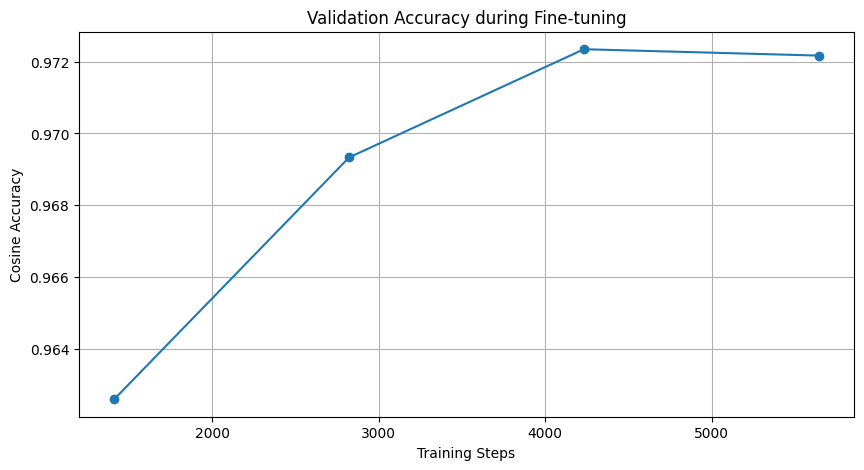

In [41]:
print("\n--- Plotting Validation Performance ---")
eval_filepath = os.path.join(OUTPUT_PATH, "eval", "triplet_evaluation_validation_results.csv")

try:
    eval_results = pd.read_csv(eval_filepath)
    # Check if 'steps' and 'cosine_accuracy' columns exist
    if 'steps' in eval_results.columns and 'accuracy_cosine' in eval_results.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(eval_results['steps'], eval_results['accuracy_cosine'], marker='o', linestyle='-')
        plt.title('Validation Accuracy during Fine-tuning')
        plt.xlabel('Training Steps')
        plt.ylabel('Cosine Accuracy')
        plt.grid(True)
        plot_save_path = os.path.join(OUTPUT_PATH, 'validation_accuracy_plot.png')
        plt.savefig(plot_save_path)
        print(f"Validation plot saved to: {plot_save_path}")
        plt.show()
    else:
        print(f"Columns 'steps' or 'accuracy_cosine' not found in {eval_filepath}. Cannot plot.")

except FileNotFoundError:
    print(f"Evaluation results file not found at: {eval_filepath}")
    print("Plotting skipped. Ensure 'write_csv=True' was set for the validation evaluator.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

## Evaluate Finetuned Model on Test

In [35]:
print(f"Loading best model from: {OUTPUT_PATH}")
model_finetuned = SentenceTransformer(OUTPUT_PATH)

# Create evaluator for the test set (identical to baseline setup)
final_test_evaluator = TripletEvaluator(
    anchors=test_anchors,
    positives=test_positives,
    negatives=test_negatives,
    name='finetuned-test',
    show_progress_bar=True
)

# Evaluate the fine-tuned model
print("Evaluating fine-tuned model on test set...")
finetuned_results = final_test_evaluator(model_finetuned)
finetuned_accuracy = finetuned_results[final_test_evaluator.primary_metric]
print(f"Fine-tuned Test Set Accuracy (Cosine): {finetuned_accuracy:.4f}")


Loading best model from: sbert-output/finetuning-all-MiniLM-L6-v2-books
Evaluating fine-tuned model on test set...


Batches: 100%|██████████| 353/353 [00:11<00:00, 29.83it/s]

Fine-tuned Test Set Accuracy (Cosine): 0.9736


### Comparison

In [36]:
print("\n--- Results Comparison ---")
print(f"Baseline Test Accuracy:   {baseline_accuracy:.4f}")
print(f"Fine-tuned Test Accuracy: {finetuned_accuracy:.4f}")
improvement = finetuned_accuracy - baseline_accuracy
print(f"Improvement:              {improvement:.4f} ({improvement/baseline_accuracy:.1%})")



--- Results Comparison ---
Baseline Test Accuracy:   0.0167
Fine-tuned Test Accuracy: 0.9736
Improvement:              0.9569 (5742.6%)


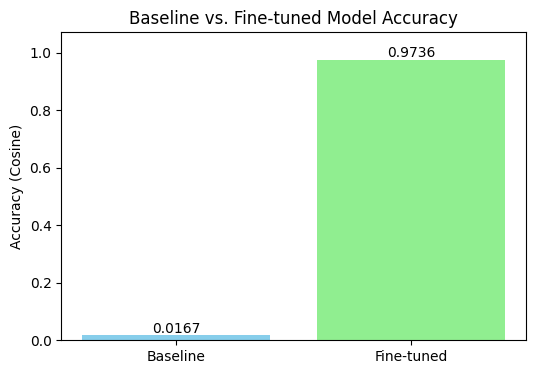

In [42]:
# Data for plotting
labels = ['Baseline', 'Fine-tuned']
accuracies = [baseline_accuracy, finetuned_accuracy]

# Create bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies, color=['skyblue', 'lightgreen'])

# Add accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') # Add text labels

plt.ylabel('Accuracy (Cosine)')
plt.title('Baseline vs. Fine-tuned Model Accuracy')
plt.ylim(0, max(accuracies) * 1.1) # Adjust y-axis limit for better visualization
plt.show()